In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit

from sfilter import sfilter

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [11]:
def c_jk(data, Dpix):
    nx = 2 * Dpix + 1 # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    
    return res

def gamma_poly(xdata, Cn2, z):
    global D, pupil, latency, sec_per_frame, pupil
    y=xdata[0]
    x=xdata[1]
    nx = 2 * pupil.shape[0] + 1 # размер окна автокорреляции зрачка, должно быть в 2 раза больше чем размер зрачка
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = pupil.shape[0]/(D*nx) # шаг по частоте, [м^-1]
    delta = D/pupil.shape[0] # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
    def gamma_poly_int(fx, fy, xx, yy, z, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res
        
        S = sfilter(D=D, Dpix=pupil.shape[0], z=z)    
    
        res = abs_f(fx, fy) * S * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    res = Cn2 * const * gamma_poly_int(fx, fy, xx, yy, z, delta) * pow(f_scale, 2) * nx * nx    
    res = shift(res, (y,x), order=5)
    res = res * c_jk(pupil, pupil.shape[0])
    
    res = res.ravel()
    
    return res

In [3]:
D = 2.5
latency = 4
sec_per_frame = 0.01
z = 2000
Cn2 = 1*pow(10, -13)

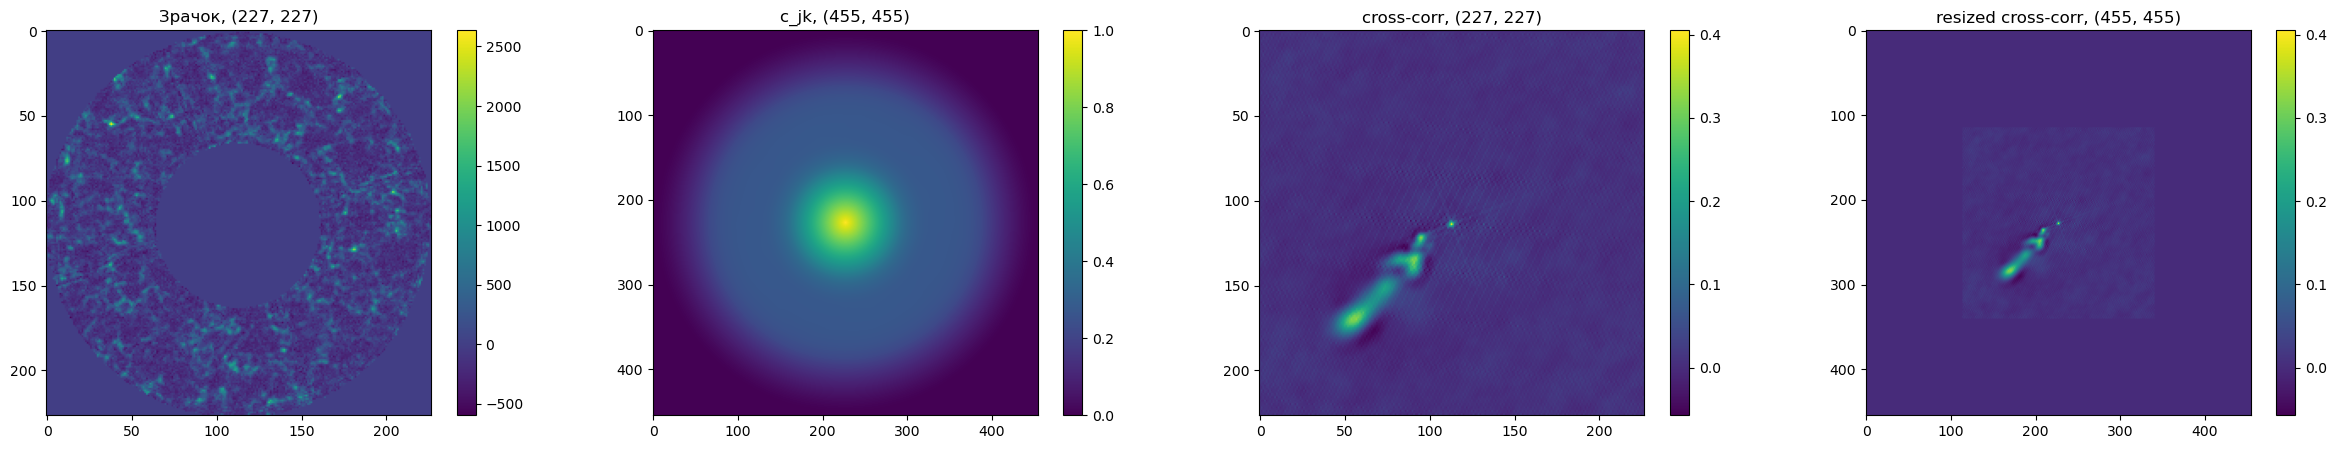

In [9]:
pupil = np.loadtxt('C:/astro/data.gz')
data_corr = np.loadtxt('C:/astro/data_corr.gz')
a = int(2*pupil.shape[0]+2 - data_corr.shape[0])//2
b = int(2*pupil.shape[1]+2 - data_corr.shape[1])//2
data = np.pad(data_corr, ((a, a), (b, b)), 'constant', constant_values=(0))

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(c_jk(pupil, pupil.shape[0])), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {c_jk(pupil, pupil.shape[0]).shape}')

fig.colorbar(ax3.imshow(data_corr), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr, {data_corr.shape}')

fig.colorbar(ax4.imshow(data), ax=ax4)
ax4.grid(False)
ax4.set_title(f'resized cross-corr, {data.shape}')

print(' ')

max value: 0.0028666540759900946
shape: (455, 455)


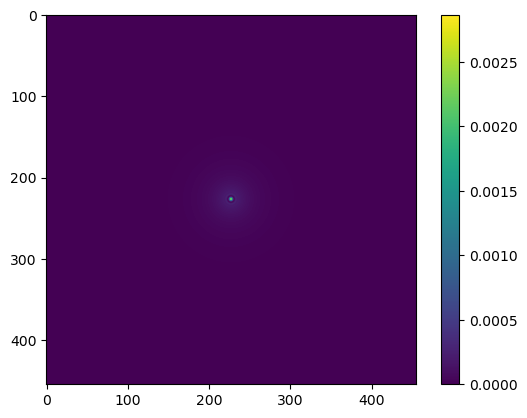

In [14]:
x=(0, 0)
test = gamma_poly(x, Cn2, z)
test = test.reshape((data.shape[0], data.shape[1]))
plt.figure()
plt.imshow(test)
plt.colorbar()

print(f'max value: {np.max(test)}')
print(f'shape: {test.shape}')

In [24]:
# ------------- масштабирование исходных данных ---------------------------
# см выше

# ---------------- xdata -------------------------------------------------
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X1, X2 = np.meshgrid(x, y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))
xdata = np.vstack((x1_1d, x2_1d))
print('xdata shape:', xdata.shape)

# ----------------- ydata ----------------------------------------
ydata = data.ravel()
print('ydata shape:', ydata.shape)

# -------------------- p0 ------------------------------------
p0 = [1*pow(10, -13), 2000, 1*pow(10, -13), 8000, 1*pow(10, -13), 10000]

xdata shape: (2, 209764)
ydata shape: (209764,)


In [ ]:
popt, pcov = curve_fit(gamma_poly, xdata, ydata, p0=p0)

popt